# Event identification

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from datetime import datetime
import os
import rioxarray
import pickle

# Sydney shape file

In [2]:
# File paths
csv_file_path = "/g/data/gb02/lk5320/DATA_stored/All_stations_information.xlsx"  
shapefile_path = '/scratch/gb02/lk5320/shp_files/Greater_syd/GCCSA_2021_AUST_GDA94.shp'  # Replace with your path
# output_file_path = "/scratch/gb02/lk5320/DATA/2_greater_SYD_stations.csv"

df = pd.read_excel(csv_file_path)

In [3]:
# Assuming df is your DataFrame with 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Load the shapefile (Greater Sydney boundary)
gdf_shapefile = gpd.read_file(shapefile_path)

# Select only the first geometry (Greater Sydney boundary) from the shapefile
greater_sydney_geom = gdf_shapefile.iloc[0]  # Assuming there's only one polygon for Greater Sydney

# Create a GeoSeries for the Greater Sydney polygon
sydney_polygon = gpd.GeoSeries([greater_sydney_geom.geometry], crs=gdf_shapefile.crs)

# Shortlisted events from excel sheet

In [4]:
events_list = "/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p5_shortlist_common_events_based_on_10min.xlsx"  
# events_list = "/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p5_shortlist_common_events_based_on_1hr.xlsx"  

events_list = pd.read_excel(events_list)

# BARRA data (1 hr)

In [ ]:
# Store results in a list
max_precip_list = []

# Loop over first 15 events
for i in range(10):
    # Extract time from the event list
    event_time = pd.to_datetime(events_list.loc[i, 'Time of 1hr P'])

    # Format YYYYMM for file naming
    yyyymm = event_time.strftime('%Y%m')

    # Construct the file path
    file_path = f'/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/pr/latest/pr_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_{yyyymm}-{yyyymm}.nc'
    # file_path = f'/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/pr/latest/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_{yyyymm}-{yyyymm}.nc'

    # Open dataset
    ds = xr.open_dataset(file_path)
    precipitation = ds['pr'] * 3600  # Convert from kg/m²/s to mm/hr

    # Select all time steps for the event's day
    selected_date = np.datetime64(event_time.date())  # Ensures correct dtype
    precip_day = precipitation.sel(time=precipitation.time.dt.date == selected_date)

    # Get max hourly precipitation at each grid point
    max_precip_day = precip_day.max(dim='time')

    # Append to list
    max_precip_list.append(max_precip_day)

# # Save the list as a .pkl file
# with open("/scratch/gb02/lk5320/python_scripts/BARRA/b1_max_precip_list_15events_10min_C2.pkl", "wb") as f:
#     pickle.dump(max_precip_list, f)

# print("Saved max_precip_list with 15 events to 'b1_max_precip_list_15events_10min_C2.pkl'")


In [ ]:
import pickle

with open("/scratch/gb02/lk5320/python_scripts/BARRA/b1_max_precip_list_15events_10min_C2.pkl", "rb") as f:
    max_precip_list = pickle.load(f)

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalize to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# All top 10 events together

In [ ]:
# Set up 3x5 subplot grid
fig, axes = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'height_ratios': [1, 1]})
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each event and corresponding precipitation map
for i in range(10):
    ax = axes[i]

    # Get event data
    event_time = pd.to_datetime(events_list.loc[i, 'Time of 1hr P'])
    event_lat = events_list.loc[i, 'Latitude']
    event_lon = events_list.loc[i, 'Longitude']
    precip_value = events_list.loc[i, 'Precipitation at 1hr']
    selected_date = event_time.strftime('%Y-%m-%d')

    # Get precipitation map
    max_precip_day = max_precip_list[i]  # xarray DataArray with rioxarray accessor

    # Plot the precipitation map
    max_precip_day.plot(ax=ax, cmap=custom_cmap, vmin=0, vmax=60, add_colorbar=False)
    
    # Set CRS if not already present
    if not max_precip_day.rio.crs:
        max_precip_day = max_precip_day.rio.write_crs(sydney_polygon.crs)

    # Clip to Sydney polygon
    clipped = max_precip_day.rio.clip(sydney_polygon.geometry, sydney_polygon.crs, drop=False)

    # Check if non-empty after clipping
    if clipped.rio.count != 0 and clipped.values[~np.isnan(clipped.values)].size > 0:
        max_val = np.nanmax(clipped.values)
        max_pos = np.unravel_index(np.nanargmax(clipped.values), clipped.shape)

        # Coordinates of the max cell
        max_y, max_x = max_pos
        x_coords = clipped.lon.values
        y_coords = clipped.lat.values

        x0 = x_coords[max_x] - (x_coords[1] - x_coords[0]) / 2
        y0 = y_coords[max_y] - (y_coords[1] - y_coords[0]) / 2
        cell_width = x_coords[1] - x_coords[0]
        cell_height = y_coords[1] - y_coords[0]

        # Draw rectangle around the max cell
        rect = plt.Rectangle((x0, y0), cell_width, cell_height, linewidth=2,
                             edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)

        # Annotate value
        ax.text(x_coords[max_x], y_coords[max_y] + 0.03, f'{max_val:.1f}', color='blue', fontsize=12, ha='center', 
                bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2', linewidth=1.5, alpha=0.7))
    
    # Overlay Sydney polygon
    sydney_polygon.plot(ax=ax, color='none', edgecolor='grey')

    # Plot event location
    ax.plot(event_lon, event_lat, marker='o', markersize=12, markerfacecolor='none',
            markeredgecolor='red', markeredgewidth=2)

    # Annotate event precipitation
    ax.text(event_lon+ 0.01, event_lat + 0.03, f'{precip_value:.1f}', color='black', fontsize=12,
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))

    # Set spatial bounds to Sydney region
    minx, miny, maxx, maxy = sydney_polygon.total_bounds
    ax.set_xlim(minx - 0.1, maxx + 0.1)
    ax.set_ylim(miny - 0.1, maxy + 0.1)

    # Remove axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # Show x-axis ticks only for bottom row (row index 2)
    if (i // 5) == 1:
        ax.xaxis.set_visible(True)
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    else:
        ax.xaxis.set_visible(False)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Show y-axis ticks only for left column (column index 0)
    if (i % 5) == 0:
        ax.yaxis.set_visible(True)
        ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    else:
        ax.yaxis.set_visible(False)
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    # Set bold date title
    ax.set_title(f'{selected_date}', fontsize=10, weight='bold')

cbar_ax = fig.add_axes([0.92, 0.11, 0.015, 0.77])
im = max_precip_list[0].plot(cmap=custom_cmap, vmin=0, vmax=40, add_colorbar=False)
cbar = fig.colorbar(im, cax=cbar_ax)  # No label
cbar_ax.set_xlabel('')    # Remove unwanted xlabel
cbar_ax.set_xticks([])    # Remove x-axis ticks

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout and overall title
# plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.suptitle('Max Hourly Precipitation (mm/hr)', fontsize=20, fontweight='bold', y=1.02)

# plt.savefig("/scratch/gb02/lk5320/python_scripts/BARRA/b1_max_hourly_precipitation_10min_C2.png", dpi=300, bbox_inches='tight')

plt.show()


# Radar plots

# historical ground reflectivity

In [5]:
import os
import xarray as xr
import numpy as np
from datetime import datetime
from pyproj import CRS, Transformer

In [6]:
import os
import zipfile
import pandas as pd

# Base folder to store extracted files
temp_base_dir = "/scratch/gb02/lk5320/python_scripts/BARRA/temp"

# Loop over top 10 events in events_list
for i in range(10):
    try:
        # Get date info
        event_time = pd.to_datetime(events_list.loc[i, 'Time of 1hr P'])
        selected_date = event_time.strftime('%Y%m%d')
        year = event_time.strftime('%Y')

        # Define possible ZIP file locations with station IDs
        zip_paths = [
            (f"/g/data/rq0/hist_gndrefl/71/{year}/71_{selected_date}.gndrefl.zip", '71'),
            (f"/g/data/rq0/rainfields3/71/{year}/gndrefl/71_{selected_date}.gndrefl.zip", '71'),
            (f"/g/data/rq0/hist_gndrefl/3/{year}/3_{selected_date}.gndrefl.zip", '3')
        ]

        # Locate first existing ZIP
        zip_path, station_id = None, None
        for path, sid in zip_paths:
            if os.path.exists(path):
                zip_path, station_id = path, sid
                break

        if zip_path is None:
            print(f"No .zip file found for {selected_date}")
            continue

        # Create output folder
        out_dir = os.path.join(temp_base_dir, selected_date)
        os.makedirs(out_dir, exist_ok=True)

        # Extract all .nc files from ZIP into the date folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            nc_files = [f for f in zip_ref.namelist() if f.endswith(".nc")]
            for f in nc_files:
                target_path = os.path.join(out_dir, os.path.basename(f))
                with zip_ref.open(f) as source, open(target_path, 'wb') as target:
                    target.write(source.read())

        print(f"✅ Extracted {len(nc_files)} files to {out_dir}")

    except Exception as e:
        print(f"❌ Error on index {i} ({selected_date}): {e}")


✅ Extracted 144 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20051002
✅ Extracted 240 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20160129
✅ Extracted 240 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20150824
✅ Extracted 288 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20231202
✅ Extracted 143 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20070301
✅ Extracted 240 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20140414
✅ Extracted 237 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20101216
✅ Extracted 240 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20190314
✅ Extracted 240 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20181017
✅ Extracted 240 files to /scratch/gb02/lk5320/python_scripts/BARRA/temp/20180907


In [7]:
# Base folder where all date folders are stored
base_folder = "/scratch/gb02/lk5320/python_scripts/BARRA/temp"

# -----------------------------
# Reflectivity to rain rate
# -----------------------------
def dBZ_to_rain_rate_mm_per_hr(reflectivity, station):
    if station == '71':
        a, b = 240.3, 1.51
    elif station == '3':
        a, b = 317, 1.66
    else:
        raise ValueError(f"Unknown station {station} for rain rate conversion")
    Z = 10 ** (reflectivity / 10.0)
    return (Z / a) ** (1 / b)


In [8]:
# -----------------------------
# Derive lat/lon using per-file Albers Equal Area projection
# -----------------------------
def add_latlon_from_proj(ds):
    proj_attrs = ds['proj'].attrs

    std_parallels = proj_attrs['standard_parallel']
    lon_0 = proj_attrs['longitude_of_central_meridian']
    lat_0 = proj_attrs['latitude_of_projection_origin']
    false_easting = proj_attrs.get('false_easting', 0.0)
    false_northing = proj_attrs.get('false_northing', 0.0)
    a = proj_attrs.get('semi_major_axis', 6378137.0)
    b = proj_attrs.get('semi_minor_axis', 6356752.31414)

    crs_proj = CRS({
        'proj': 'aea',
        'lat_1': std_parallels[0],
        'lat_2': std_parallels[1],
        'lat_0': lat_0,
        'lon_0': lon_0,
        'x_0': false_easting,
        'y_0': false_northing,
        'a': a,
        'b': b,
        'units': 'km',
        'datum': 'WGS84'
    })

    crs_geo = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(crs_proj, crs_geo, always_xy=True)

    x = ds['x'].values
    y = ds['y'].values
    xx, yy = np.meshgrid(x, y)

    lon, lat = transformer.transform(xx, yy)

    return xr.DataArray(
        ds['reflectivity'].values,
        dims=('y', 'x'),
        coords={'lat': (('y', 'x'), lat),
                'lon': (('y', 'x'), lon)},
        name='reflectivity'
    )


In [9]:
# -----------------------------
# Store max rain rate for each date
# -----------------------------
daily_max_rain_rates = {}

# Loop over each date folder
for date_folder in sorted(os.listdir(base_folder)):
    folder_path = os.path.join(base_folder, date_folder)
    if not os.path.isdir(folder_path):
        continue

    try:
        date_obj = datetime.strptime(date_folder, "%Y%m%d")
        station = '3' if date_obj.year < 2009 else '71'

        nc_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".nc")])
        if not nc_files:
            print(f"No .nc files in {folder_path}")
            continue

        rain_rate_list = []

        for f in nc_files:
            file_path = os.path.join(folder_path, f)
            ds = xr.open_dataset(file_path)

            if 'reflectivity' not in ds:
                print(f"'reflectivity' missing in {f}")
                continue

            # Convert reflectivity to DataArray with lat/lon
            try:
                reflectivity_da = add_latlon_from_proj(ds)
            except Exception as e:
                print(f"Lat/lon derivation failed for {f}: {e}")
                continue

            # Convert to rain rate
            rain_rate = dBZ_to_rain_rate_mm_per_hr(reflectivity_da, station)

            rain_rate_list.append(rain_rate)

        if not rain_rate_list:
            print(f"No valid rain data in {folder_path}")
            continue

        # Stack along dummy time axis and compute max
        rain_rate_stack = xr.concat(rain_rate_list, dim='time')
        max_rain = rain_rate_stack.max(dim='time')

        daily_max_rain_rates[date_folder] = max_rain
        print(f"✅ Processed {date_folder}: shape {max_rain.shape}, station {station}")

    except Exception as e:
        print(f"❌ Error processing folder {date_folder}: {e}")


✅ Processed 20051002: shape (512, 512), station 3
✅ Processed 20070301: shape (512, 512), station 3
✅ Processed 20101216: shape (512, 512), station 71
✅ Processed 20140414: shape (512, 512), station 71
✅ Processed 20150824: shape (512, 512), station 71
✅ Processed 20160129: shape (512, 512), station 71
✅ Processed 20180907: shape (512, 512), station 71
✅ Processed 20181017: shape (512, 512), station 71
✅ Processed 20190314: shape (512, 512), station 71
✅ Processed 20231202: shape (512, 512), station 71


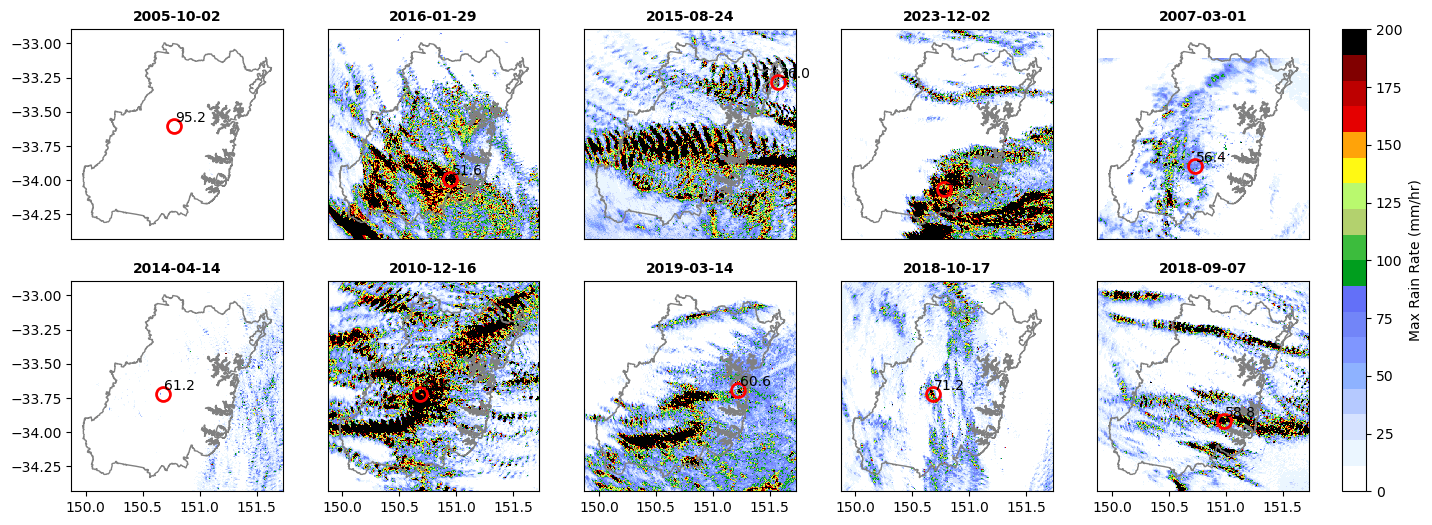

In [34]:
import numpy as np
import matplotlib.pyplot as plt

n = 10
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6), gridspec_kw={'height_ratios': [1, 1]})

mesh = None  # for colorbar

for idx, ax in enumerate(axs.flat):
    if idx < n:
    # Get event metadata
        event_time = pd.to_datetime(events_list.loc[idx, 'Time of 1hr P'])
        selected_date = event_time.strftime('%Y%m%d')  # match folder/key
        event_lat = events_list.loc[idx, 'Latitude']
        event_lon = events_list.loc[idx, 'Longitude']
        precip_value = events_list.loc[idx, 'Precipitation at 1hr']
        date_label = event_time.strftime('%Y-%m-%d')

        # Fetch the corresponding rain map
        if selected_date not in daily_max_rain_rates:
            print(f"⚠️ Missing rain rate data for event on {selected_date}")
            ax.axis('off')
            continue

        rain_rate = daily_max_rain_rates[selected_date]

        # Check lat/lon
        if 'lat' not in rain_rate.coords or 'lon' not in rain_rate.coords:
            print(f"Missing lat/lon in {date_key}")
            ax.axis('off')
            continue

        lat_2d = rain_rate['lat'].values
        lon_2d = rain_rate['lon'].values

        # Handle 2D or 1D grids
        if lat_2d.ndim == 2 and lon_2d.ndim == 2:
            lat_edges = np.linspace(lat_2d.max(), lat_2d.min(), lat_2d.shape[0] + 1)
            lon_edges = np.linspace(lon_2d.min(), lon_2d.max(), lon_2d.shape[1] + 1)
        else:
            lat_edges = np.linspace(lat_2d.max(), lat_2d.min(), len(lat_2d) + 1)
            lon_edges = np.linspace(lon_2d.min(), lon_2d.max(), len(lon_2d) + 1)

        # Plot
        mesh = ax.pcolormesh(lon_edges, lat_edges, rain_rate.values, shading='auto',
                             cmap=custom_cmap, vmin=0, vmax=200)

        # Overlay Sydney outline if available
        if 'sydney_polygon' in globals():
            sydney_polygon.plot(ax=ax, color='none', edgecolor='grey')

        # Plot event point
        ax.plot(event_lon, event_lat, marker='o', markersize=10,markerfacecolor='none', markeredgecolor='red', markeredgewidth=2)

        # Annotate rain amount
        ax.text(event_lon + 0.01, event_lat + 0.03, f'{precip_value:.1f}', color='black', fontsize=10,bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))

        # Map extent
        if 'sydney_polygon' in globals():
            minx, miny, maxx, maxy = sydney_polygon.total_bounds
            ax.set_xlim(minx - 0.1, maxx + 0.1)
            ax.set_ylim(miny - 0.1, maxy + 0.1)
        else:
            ax.set_xlim(lon_2d.min(), lon_2d.max())
            ax.set_ylim(lat_2d.min(), lat_2d.max())

        # Axis tick visibility
        if idx // ncols == nrows - 1:
            ax.xaxis.set_visible(True)
            ax.tick_params(axis='x', labelbottom=True)
        else:
            ax.xaxis.set_visible(False)

        if idx % ncols == 0:
            ax.yaxis.set_visible(True)
            ax.tick_params(axis='y', labelleft=True)
        else:
            ax.yaxis.set_visible(False)

        # Title
        ax.set_title(f'{date_label}', fontsize=10, weight='bold')
    else:
        ax.axis('off')

# Shared colorbar
if mesh:
    cbar_ax = fig.add_axes([0.92, 0.11, 0.015, 0.77])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    cbar.set_label('Max Rain Rate (mm/hr)')
    cbar_ax.set_xticks([])

# plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig("/scratch/gb02/lk5320/python_scripts/BARRA/b1_max_rain_rates_radar_10min.png", dpi=600, bbox_inches='tight')
plt.show()
